# Homework 3

Before starting notebook, activate viz: *jupyter nbextension enable vega --py*

In [446]:
import pandas as pd
import numpy as np
import folium
import branca.colormap as cm
import json
import os
import csv
%matplotlib inline

## Initial variables and helper functions

In [447]:
topo_path_json_eu = os.path.join('topojson', 'europe.topojson.json')
topo_path_json_ch = os.path.join('topojson', 'ch-cantons.topojson.json')

path_unemployment_eu_month = os.path.join('FetchedData', 'Unemployment_rate_EU.tsv')

color_undef = "#bdbdbd"

# picked with colorbrewer, orange since unemployment rate is bad
color_classes = ['#fef0d9','#fdcc8a','#fc8d59','#e34a33','#b30000']
color_classes_swiss = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000']

## Our definition of unemployment rate

We define unemployment rate as the quaterly seasonal adjusted rate of people who declared their unemployment, while having no job.
We do not differentiate between male and female or ages.

# Color choose

We choose a red teint , and between 5 and 6 intervals. As it is in % and it varies between 1 and 6 , we could argue that this is a preferable choice.

The red is used as the highest the darker it is and it connotes to a negative impression ( indeed unemployment is not positive )

## Unemployment rate in Europe at a country level

The chosen dataset from the EU contains information for people of the ages 15 - 74.  
We picked the dataset which differentiates between education, because it contains Switzerland. The basic datasets did not contain Switzerland.  
In order to calculate the total unemployment rate we took the mean of the unemployment rate of the educational classes.

In [448]:
map_europe = folium.Map([57,18], zoom_start=3, tiles='cartodbpositron')

### Preprocess downloaded data

In [449]:
df_unemployment_eu_month = pd.read_csv(path_unemployment_eu_month, sep='\t')
df_unemployment_eu_month.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,2017Q1,2016Q4,2016Q3,2016Q2,2016Q1,2015Q4,2015Q3,2015Q2,...,2000Q2,2000Q1,1999Q4,1999Q3,1999Q2,1999Q1,1998Q4,1998Q3,1998Q2,1998Q1
0,"F,ED0-2,Y15-74,NSA,PC_ACT,AT",11.2,12.3,11.4,11.3,10.6,10.3,9.8,9.3,9.6,...,5.7,7.3,5.5,5.0,4.7,6.7,:,:,:,8.6
1,"F,ED0-2,Y15-74,NSA,PC_ACT,BE",14.3,17.5 b,13.0,17.4,16.7,17.3,16.4,14.7,15.8,...,14.1,15.8,16.3,16.9,17.3,18.8 b,:,:,19.3,:
2,"F,ED0-2,Y15-74,NSA,PC_ACT,BG",19.1,26.0,22.1,20.9,24.2,26.8,24.8,24.5,26.0,...,27.2,34.9,:,:,:,:,:,:,:,:
3,"F,ED0-2,Y15-74,NSA,PC_ACT,CH",8.5,9.4,9.2,9.1,9.4,9.3,7.5,11.3,9.0,...,:,:,:,:,:,:,:,:,:,:
4,"F,ED0-2,Y15-74,NSA,PC_ACT,CY",11.5,14.2,13.0,10.9,12.3,13.9,8.5,13.4,16.1,...,8.6,:,:,:,:,:,:,:,:,:


In [450]:
# Filter colums: Only use latest month
cols_drop = [i for i in range(2,len(df_unemployment_eu_month.columns))]
df_unemployment_eu_month_clean = df_unemployment_eu_month.drop(df_unemployment_eu_month.columns[cols_drop], axis=1)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2
0,"F,ED0-2,Y15-74,NSA,PC_ACT,AT",11.2
1,"F,ED0-2,Y15-74,NSA,PC_ACT,BE",14.3
2,"F,ED0-2,Y15-74,NSA,PC_ACT,BG",19.1
3,"F,ED0-2,Y15-74,NSA,PC_ACT,CH",8.5
4,"F,ED0-2,Y15-74,NSA,PC_ACT,CY",11.5


In [451]:
# Filter rows
"""
T := male and female
* := keep all educational classes
Y15-74 := maximum age range
SA := seasonal adjusted
PC_ACT = percentage of popolation
"""
unempl_filter = r"^T,(.*),Y15-74,SA,PC_ACT,(.*)"
df_unemployment_eu_month_clean = df_unemployment_eu_month_clean[df_unemployment_eu_month_clean.iloc[:,0].str.contains(unempl_filter)]
df_unemployment_eu_month_clean.head()

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,"sex,isced11,age,s_adj,unit,geo\time",2017Q2
4368,"T,ED0-2,Y15-74,SA,PC_ACT,AT",13.1
4369,"T,ED0-2,Y15-74,SA,PC_ACT,BE",15.2
4370,"T,ED0-2,Y15-74,SA,PC_ACT,BG",18.5
4371,"T,ED0-2,Y15-74,SA,PC_ACT,CH",8.4
4372,"T,ED0-2,Y15-74,SA,PC_ACT,CY",14.8


In [452]:
# Filter country id
df_unemployment_eu_month_clean["country"] = df_unemployment_eu_month_clean.iloc[:,0].replace({ unempl_filter : r'\2'}, regex=True)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,"T,ED0-2,Y15-74,SA,PC_ACT,AT",13.1,AT
4369,"T,ED0-2,Y15-74,SA,PC_ACT,BE",15.2,BE
4370,"T,ED0-2,Y15-74,SA,PC_ACT,BG",18.5,BG
4371,"T,ED0-2,Y15-74,SA,PC_ACT,CH",8.4,CH
4372,"T,ED0-2,Y15-74,SA,PC_ACT,CY",14.8,CY


In [453]:
# Reformat filter to only contain education category
df_unemployment_eu_month_clean.iloc[:,0] = df_unemployment_eu_month_clean.iloc[:,0].replace({ unempl_filter : r'\1'}, regex=True)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,ED0-2,13.1,AT
4369,ED0-2,15.2,BE
4370,ED0-2,18.5,BG
4371,ED0-2,8.4,CH
4372,ED0-2,14.8,CY


In [454]:
# Replace unkown values, denoted by ":", remove "u" warning for low accuracy
df_unemployment_eu_month_clean.iloc[:,1] = df_unemployment_eu_month_clean.iloc[:,1].apply(
    lambda x : x.replace("u", ""))
df_unemployment_eu_month_clean.iloc[:,1] = df_unemployment_eu_month_clean.iloc[:,1].apply(
    lambda x : np.NAN if ":" in x else x)
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,ED0-2,13.1,AT
4369,ED0-2,15.2,BE
4370,ED0-2,18.5,BG
4371,ED0-2,8.4,CH
4372,ED0-2,14.8,CY


In [455]:
# convert unemployment to float
df_unemployment_eu_month_clean.iloc[:,1] = pd.to_numeric(df_unemployment_eu_month_clean.iloc[:,1], errors='coerce')
df_unemployment_eu_month_clean.head()

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
4368,ED0-2,13.1,AT
4369,ED0-2,15.2,BE
4370,ED0-2,18.5,BG
4371,ED0-2,8.4,CH
4372,ED0-2,14.8,CY


In [456]:
pd.isnull(df_unemployment_eu_month_clean).any()

sex,isced11,age,s_adj,unit,geo\time    False
2017Q2                                  True
country                                False
dtype: bool

In [457]:
df_unemployment_eu_month_clean[pd.isnull(df_unemployment_eu_month_clean.iloc[:,1])]

,"sex,isced11,age,s_adj,unit,geo\time",2017Q2,country
5812,ED5-8,NaN,MT


Use default behavior of pandas and calculate mean with only two education categories

In [458]:
df_unemployment_eu_month_clean = df_unemployment_eu_month_clean.groupby("country").mean()
df_unemployment_eu_month_clean.head()

,2017Q2
country,
AT,7.033333
BE,8.900000
BG,8.900000
CH,5.533333
CY,11.900000


In [459]:
df_unemployment_eu_month_clean.iloc[:,0].sort_values().head(10)

country
IS    2.766667
RO    4.733333
MT    4.900000
DE    4.933333
UK    5.000000
NO    5.200000
CH    5.533333
NL    5.566667
LU    5.700000
HU    5.800000
Name: 2017Q2 , dtype: float64

### Create vizualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C7F83B9C88>]], dtype=object)

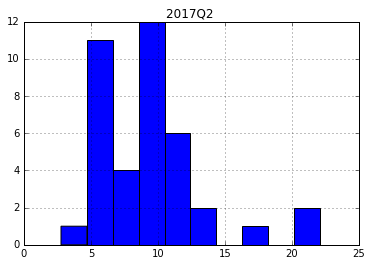

In [460]:
df_unemployment_eu_month_clean.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C7FA2912E8>]], dtype=object)

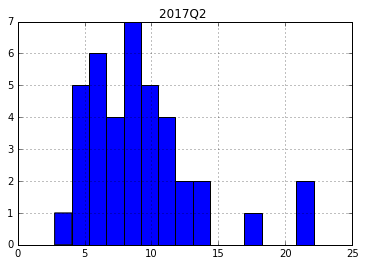

In [461]:
df_unemployment_eu_month_clean.hist(bins=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C7FDCE8BE0>]], dtype=object)

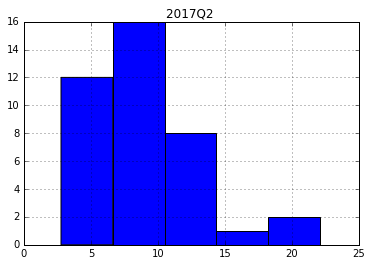

In [462]:
df_unemployment_eu_month_clean.hist(bins=5)

We decided to take 5 bins, since not to much information gets lost and more than seven colors can only hardly be distincted

In [463]:
def eu_map_country_id(country_id_geo_json):
    """Handles Mapping between country ids"""
    if country_id_geo_json == "FR":
        return "FX"
    elif country_id_geo_json == "GB":
        return "UK"
    elif country_id_geo_json == "GR":
        return "EL"
    else:
        return country_id_geo_json

In [464]:
def eu_get_unemployment_rate(country_id, df):
    """Fetches the unemployment rate for a given country from the data frame"""
    try:
        row = df.loc[eu_map_country_id(country_id)].values
        return row[0]
    except KeyError:
        #print ("Country with id {} not found in dataset".format(country_id))
        return -1

In [465]:
# calculate bin for unemployment
def get_class(unempl_rate, df,map_):
    if(map_=='ch'):
        i=1
    else:
        i=0
    count, division = np.histogram(df.iloc[:,i], bins=5)
    """Calculates the class based on the real value"""
    if unempl_rate < division[1]:
        return 0
    elif unempl_rate < division[2]:
        return 1
    elif unempl_rate < division[3]:
        return 2
    elif unempl_rate < division[4]:
        return 3
    else:
        return 4

In [466]:
# calculate bin for unemployment
def get_class_swiss(unempl_rate, df,map_):
    if(map_=='ch'):
        i=1
    else:
        i=0
    count, division = np.histogram(df.iloc[:,i], bins=6)
    """Calculates the class based on the real value"""
    if unempl_rate < division[1]:
        return 0
    elif unempl_rate < division[2]:
        return 1
    elif unempl_rate < division[3]:
        return 2
    elif unempl_rate < division[4]:
        return 3
    elif unempl_rate < division[5]:
        return 4
    else :
        return 5
        

In [467]:
def class_color(class_id):
    """Fetches the color code based on the class"""
    return color_classes[class_id]

In [468]:
def unemployment_colors(id_,df, map_):
    """Returns the color based on the unemployment rate for the given country"""
    if(map_ == 'eu'):
        unempl_rate = eu_get_unemployment_rate(id_,df)
    elif(map_=='ch'):
        unempl_rate = ch_get_unemployment_rate(id_,df)
                               
    if unempl_rate == -1:
        return color_undef
    else:
        id_ = get_class(unempl_rate,df,map_)
        return class_color(id_)

In [469]:
with open(topo_path_json_eu) as f:
    
    j = json.load(f)
    
    # Create an own topojson object in order to display popups 
    topojson = [{'type': j['type'],
                 'objects': {'europe': {
                     'type': "GeometryCollection",
                     'geometries': [f]}},
                 'arcs' : j['arcs'],
                 'transform' : j['transform']} 
                for f in j['objects']['europe']['geometries']]
    
    # Add each topojson
    for tj in map(lambda tj: folium.TopoJson(tj,
                                             "objects.europe", style_function=lambda country: {
                                                'fillColor': unemployment_colors(country['id'],df_unemployment_eu_month_clean,'eu'),
                                                'fillOpacity': 1,
                                                'weight': 1,
                                                'color' : 'black',
                                                'dashArray' : '0, 0'}),
                  topojson):
        
        # fetch details for popup
        unemployment_rate = eu_get_unemployment_rate(tj.data['objects']['europe']['geometries'][0]['id'],df_unemployment_eu_month_clean)
        country = tj.data['objects']['europe']['geometries'][0]['properties']['NAME']
    
        # beautify popup
        if unemployment_rate == -1:
            html = """
                <h3> """+country+""" </h3> </br>
                <p> Unemployment rate: unavailable </p> """
        else :
            html = """
                <h3> """+country+""" </h3> </br>
                <p> Unemployment rate: """+"{0:.2f}%".format(unemployment_rate)+""" </p> """
            
        # add popup and topojson
        tj.add_child(folium.Popup(html))
        tj.add_to(map_europe)

In [470]:
# Add legend
count, division = np.histogram(df_unemployment_eu_month_clean.iloc[:,0], bins=5)
min_ = min(df_unemployment_eu_month_clean.values)[0]
max_= max(df_unemployment_eu_month_clean.values)[0]

colormap = cm.StepColormap(
            color_classes,
            index=division,
            vmin=min_,
            vmax=max_,
            caption="Unemployment rate [%]",
            )
map_europe = map_europe.add_child(colormap)

In [471]:
# Moves slowly due to many topojsons, but has popups :)
map_europe.save('EU_unemployment_rate.html')

Access the map from Jupyter [here](EU_unemployment_rate.html).  
Access the map from Github [here](https://cdn.rawgit.com/maxpr/ADA/90fd3cef/03%20-%20Interactive%20Viz/EU_unemployment_rate.html).  
Click on the countries in order to display the exact unemployment rate of the country.

### Comparison Switzerland to the rest of Europe

Switzerland's unemployment rate puts Switzerland in the first class, which has the lowest unemployment rate in Europe.  
This means that Switzerland's unemployment rate is between 3% and 7%
Exactly Switzerland is the country with the 7th lowest unemployment rate of 5.53% .

## Unemployment rate in Switzerland at a canton level

We take the unemployment Rate in % from the website, and aggregate the second quarter of year 2017 ( April , March and July) tjo have the same measurement as Europe

In [472]:
map_switzerland = folium.Map([47,9], zoom_start=7, tiles='cartodbpositron')


In [473]:
unemployment_swiss = os.path.join('FetchedData', 'Unemployment_rate_Switzerland.xlsx')
df_unemployment_swiss = pd.read_excel(unemployment_swiss)
df_unemployment_swiss.head()


,Canton,Mois,Janvier 2017,Février 2017,Mars 2017,Avril 2017,Mai 2017,Juin 2017,Juillet 2017,Août 2017,Septembre 2017,Octobre 2017,Total
0,NaN,Mesures,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage,Taux de chômage
1,Zurich,NaN,3.9,3.9,3.8,3.6,3.5,3.4,3.4,3.4,3.3,0,3.2
2,Berne,NaN,3,3,2.9,2.7,2.6,2.4,2.4,2.5,2.4,0,2.4
3,Lucerne,NaN,2.2,2.2,2,1.9,1.8,1.7,1.7,1.8,1.7,0,1.7
4,Uri,NaN,1.5,1.4,1.3,1.2,1,0.8,0.7,0.6,0.6,0,0.9


In [474]:
#Take only the 3 month interested ( 2 quarter)
df_unemployment_swiss = df_unemployment_swiss[['Canton','Avril 2017','Mai 2017','Juin 2017']]
df_unemployment_swiss.head()


,Canton,Avril 2017,Mai 2017,Juin 2017
0,NaN,Taux de chômage,Taux de chômage,Taux de chômage
1,Zurich,3.6,3.5,3.4
2,Berne,2.7,2.6,2.4
3,Lucerne,1.9,1.8,1.7
4,Uri,1.2,1,0.8


Drop the first colum and last one which are title and total

In [475]:
#Drop the first line that is useless and last one
df_unemployment_swiss = df_unemployment_swiss.drop(0)
df_unemployment_swiss = df_unemployment_swiss.drop(27)


In [476]:
#Put the rate into numerics
df_unemployment_swiss['Avril 2017'] = pd.to_numeric(df_unemployment_swiss['Avril 2017'])
df_unemployment_swiss['Mai 2017'] = pd.to_numeric(df_unemployment_swiss['Mai 2017'])
df_unemployment_swiss['Juin 2017'] = pd.to_numeric(df_unemployment_swiss['Juin 2017'])


In [477]:
#do the mean of 3 month to get the second quartile data and create new DF with only this value
df_unemployment_swiss['2017Q2'] = df_unemployment_swiss['Avril 2017'] + df_unemployment_swiss['Mai 2017'] + df_unemployment_swiss['Juin 2017']
df_unemployment_swiss['2017Q2'] = df_unemployment_swiss['2017Q2'].apply(lambda x : x/3)
df_unemployment_swiss_cleaned = df_unemployment_swiss[['Canton','2017Q2']]
df_unemployment_swiss_cleaned


,Canton,2017Q2
1,Zurich,3.500000
2,Berne,2.566667
3,Lucerne,1.800000
4,Uri,1.000000
5,Schwyz,1.700000
6,Obwald,0.866667
7,Nidwald,1.066667
8,Glaris,2.133333
9,Zoug,2.400000
10,Fribourg,2.500000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C7FC491240>]], dtype=object)

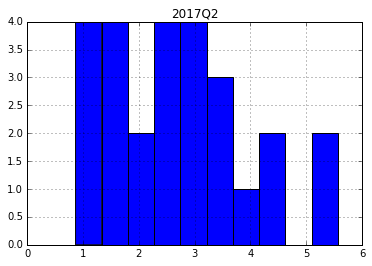

In [478]:
df_unemployment_swiss_cleaned.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C780085DD8>]], dtype=object)

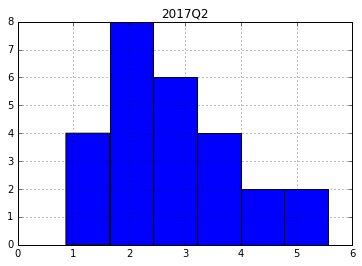

In [479]:
#6 make kind of more sens
df_unemployment_swiss_cleaned.hist(bins=6)

In [480]:
def reform(canton_name):
    if(canton_name=="Zug"):
        return "Zoug"
    if(canton_name[0]=='Z'):
        return "Zurich"
    if(canton_name[:4]=="Bern"):
        return "Berne"
    if(canton_name=="Luzern"):
        return "Lucerne"
    if(canton_name[0]=="O"):
        return "Obwald"
    if(canton_name[:2]=="Ni"):
        return "Nidwald"
    if(canton_name[:2]=='Gl'):
        return 'Glaris'
    if(canton_name[:3]=="Sol"):
        return 'Soleure'
    if(canton_name[:7]=="Basel-S"):
        return 'Bâle-Ville'
    if(canton_name[:7]=="Basel-L"):
        return 'Bâle-Campagne'
    if(canton_name[:3]=="Sch"):
        return 'Schaffhouse'
    if(canton_name[:11]=='Appenzell A'):
        return 'Appenzell Rhodes-Extérieures'
    if(canton_name[:11]=='Appenzell I'):
        return 'Appenzell Rhodes-Intérieures'
    if(canton_name[:2]=='St'):
        return 'St-Gall'
    if(canton_name[:3]=="Gra"):
        return 'Grisons'
    if(canton_name[:2]=="Aa"):
        return 'Argovie'
    if(canton_name[:2]=='Th'):
        return 'Thurgovie'
    if(canton_name[:2]=="Ti"):
        return 'Tessin'
    if(canton_name[:6]=='Valais'):
        return canton_name[:6]
    if(canton_name[:3]=='Neu'):
        return "Neuchâtel"
    if(canton_name[:2]=="Ge"):
        return "Genève"
    return canton_name

In [481]:
def ch_map_canton_id(canton_id_geo_json):
    if(canton_id_geo_json=="Zug"):
        return "Zoug"
    if(canton_id_geo_json[0]=='Z'):
        return "Zurich"
    if(canton_id_geo_json[:4]=="Bern"):
        return "Berne"
    if(canton_id_geo_json=="Luzern"):
        return "Lucerne"
    if(canton_id_geo_json[0]=="O"):
        return "Obwald"
    if(canton_id_geo_json[:2]=="Ni"):
        return "Nidwald"
    if(canton_id_geo_json[:2]=='Gl'):
        return 'Glaris'
    if(canton_id_geo_json[:3]=="Sol"):
        return 'Soleure'
    if(canton_id_geo_json[:7]=="Basel-S"):
        return 'Bâle-Ville'
    if(canton_id_geo_json[:7]=="Basel-L"):
        return 'Bâle-Campagne'
    if(canton_id_geo_json[:3]=="Sch"):
        return 'Schaffhouse'
    if(canton_id_geo_json[:11]=='Appenzell A'):
        return 'Appenzell Rhodes-Extérieures'
    if(canton_id_geo_json[:11]=='Appenzell I'):
        return 'Appenzell Rhodes-Intérieures'
    if(canton_id_geo_json[:2]=='St'):
        return 'St-Gall'
    if(canton_id_geo_json[:3]=="Gra"):
        return 'Grisons'
    if(canton_id_geo_json[:2]=="Aa"):
        return 'Argovie'
    if(canton_id_geo_json[:2]=='Th'):
        return 'Thurgovie'
    if(canton_id_geo_json[:2]=="Ti"):
        return 'Tessin'
    if(canton_id_geo_json[:6]=='Valais'):
        return canton_id_geo_json[:6]
    if(canton_id_geo_json[:3]=='Neu'):
        return "Neuchâtel"
    if(canton_id_geo_json[:2]=="Ge"):
        return "Genève"
    return canton_id_geo_json


In [482]:
def ch_get_unemployment_rate(id_,df):
    """Fetches the unemployment rate for a given country from the data frame"""
    try:
        row = df.loc[df['Canton'] == ch_map_canton_id(id_)].values   
        if(row.shape[0]==0):
            return -1
        return row[0][1]
    except KeyError:
        print ("Canton with id {} not found in dataset".format(id_))
        return -1


In [483]:

with open(topo_path_json_ch) as f:
    
    j = json.load(f)
    
    # Create an own topojson object in order to display popups 
    topojson = [{'type': j['type'],
                 'objects': {'cantons': {
                     'type': "GeometryCollection",
                     'geometries': [f]}},
                 'arcs' : j['arcs'],
                 'transform' : j['transform']} 
                for f in j['objects']['cantons']['geometries']]
    
    # Add each topojson
    for tj in map(lambda tj: folium.TopoJson(tj,
                                             "objects.cantons", style_function=lambda cantons: {
                                                'fillColor': unemployment_colors(cantons['properties']['name'],df_unemployment_swiss_cleaned,'ch'),
                                                'fillOpacity': 1,
                                                'weight': 1,
                                                'color' : 'black',
                                                'dashArray' : '0, 0'}),
                  topojson):
        
        # fetch details for popup
        canton = reform(tj.data['objects']['cantons']['geometries'][0]['properties']['name'])
        unemployment_rate = ch_get_unemployment_rate(canton,df_unemployment_swiss_cleaned)
        
    
        # beautify popup
        if unemployment_rate == -1:
            html = """
                <h3> """+canton+""" </h3> </br>
                <p> Unemployment rate: unavailable </p> """
        else :
            html = """
                <h3> """+canton+""" </h3> </br>
                <p> Unemployment rate: """+"{0:.2f}%".format(unemployment_rate)+""" </p> """
            
        # add popup and topojson
        tj.add_child(folium.Popup(html))
        tj.add_to(map_switzerland)

In [484]:
# Add legend
min_ = min(df_unemployment_swiss['2017Q2'])
max_= max(df_unemployment_swiss_cleaned['2017Q2'])
count, division = np.histogram(df_unemployment_swiss_cleaned.iloc[:,1], bins=6)

colormap = cm.StepColormap(
            color_classes_swiss,
            index=division,
            vmin=min_,
            vmax=max_,
            caption="Unemployment rate [%]",
            )
map_switzerland = map_switzerland.add_child(colormap)

In [485]:
map_switzerland.save('swiss_unemployment_rate.html')

We can see that the border canton are the one with the highest unemployment rate mostly west and north one (between 3 and 5 %)

The smaller canton in the east which are the oldest one have the lowest rate ( less than 2 %)
The mean unemployment rate is lower than the one we found with the europe map, might mostly be a difference between the calculation of global statistics.


Click [here](swiss_unemployment_rate.html) to access the map from jupyter notebook.

Click [here](https://cdn.rawgit.com/maxpr/ADA/348439a5434c90edee25b42da79bd0443eb42126/03%20-%20Interactive%20Viz/swiss_unemployment_rate.html) to access the map from Github.

Click on the cantons to know the exact rates.

# Difference betweeen unemployed and job asker

In [486]:
map_switzerland2 = folium.Map([47,9], zoom_start=7, tiles='cartodbpositron')


In [487]:
jobasker_swiss = os.path.join('FetchedData', 'Unemployed_Jobasker_Swiss.xlsx')
df_jobasker_swiss = pd.read_excel(jobasker_swiss)
df_jobasker_swiss.head()

,Canton,Mois,Janvier 2017,Janvier 2017.1,Février 2017,Février 2017.1,Mars 2017,Mars 2017.1,Avril 2017,Avril 2017.1,Mai 2017,Mai 2017.1,Juin 2017,Juin 2017.1,Juillet 2017,Juillet 2017.1,Août 2017,Août 2017.1,Septembre 2017,Septembre 2017.1
0,NaN,Mesures,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi
1,Zurich,NaN,32387,39340,31619,38748,30841,38051,29542,36610,28624,35784,27925,35134,27992,35112,27514,34542,27225,34156
2,Berne,NaN,16954,21586,16738,21367,16035,20889,15322,19882,14397,19019,13590,18230,13633,18442,13829,18393,13658,18385
3,Lucerne,NaN,4985,7950,4808,7857,4493,7574,4315,7303,4082,7091,3884,6914,3875,6805,3992,6853,3885,6756
4,Uri,NaN,297,464,276,457,256,431,228,394,196,359,159,294,129,265,123,267,112,257


Get only the interesting month

In [488]:
df_jobasker_swiss = df_jobasker_swiss[['Canton','Avril 2017','Avril 2017.1','Mai 2017','Mai 2017.1','Juin 2017','Juin 2017.1']]
df_jobasker_swiss.head()

,Canton,Avril 2017,Avril 2017.1,Mai 2017,Mai 2017.1,Juin 2017,Juin 2017.1
0,NaN,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi,Chômeurs inscrits,Demandeurs d'emploi
1,Zurich,29542,36610,28624,35784,27925,35134
2,Berne,15322,19882,14397,19019,13590,18230
3,Lucerne,4315,7303,4082,7091,3884,6914
4,Uri,228,394,196,359,159,294


In [489]:
#Remove first and last column and put to numeric
df_jobasker_swiss = df_jobasker_swiss.drop(0)
df_jobasker_swiss = df_jobasker_swiss.drop(27)


In [490]:
df_jobasker_swiss['Avril 2017'] = pd.to_numeric(df_jobasker_swiss['Avril 2017'])
df_jobasker_swiss['Mai 2017'] = pd.to_numeric(df_jobasker_swiss['Mai 2017'])
df_jobasker_swiss['Juin 2017'] = pd.to_numeric(df_jobasker_swiss['Juin 2017'])
df_jobasker_swiss['Avril 2017.1'] = pd.to_numeric(df_jobasker_swiss['Avril 2017.1'])
df_jobasker_swiss['Mai 2017.1'] = pd.to_numeric(df_jobasker_swiss['Mai 2017.1'])
df_jobasker_swiss['Juin 2017.1'] = pd.to_numeric(df_jobasker_swiss['Juin 2017.1'])

df_jobasker_swiss.head()

,Canton,Avril 2017,Avril 2017.1,Mai 2017,Mai 2017.1,Juin 2017,Juin 2017.1
1,Zurich,29542,36610,28624,35784,27925,35134
2,Berne,15322,19882,14397,19019,13590,18230
3,Lucerne,4315,7303,4082,7091,3884,6914
4,Uri,228,394,196,359,159,294
5,Schwyz,1580,2389,1462,2262,1411,2240


In [491]:
#do the mean of 3 month to get the second quartile data and create new DF with only this value
df_jobasker_swiss['2017Q2Unemployed'] = df_jobasker_swiss['Avril 2017'] + df_jobasker_swiss['Mai 2017'] + df_jobasker_swiss['Juin 2017']
df_jobasker_swiss['2017Q2Unemployed'] = df_jobasker_swiss['2017Q2Unemployed'].apply(lambda x : x/3)

df_jobasker_swiss['2017Q2JobAsker'] = df_jobasker_swiss['Avril 2017.1'] + df_jobasker_swiss['Mai 2017.1'] + df_jobasker_swiss['Juin 2017.1']
df_jobasker_swiss['2017Q2JobAsker'] = df_jobasker_swiss['2017Q2JobAsker'].apply(lambda x : x/3)


df_jobasker_cleaned = df_jobasker_swiss[['Canton','2017Q2Unemployed','2017Q2JobAsker']]


df_jobasker_cleaned

,Canton,2017Q2Unemployed,2017Q2JobAsker
1,Zurich,28697.000000,35842.666667
2,Berne,14436.333333,19043.666667
3,Lucerne,4093.666667,7102.666667
4,Uri,194.333333,349.000000
5,Schwyz,1484.333333,2297.000000
6,Obwald,182.000000,341.666667
7,Nidwald,259.000000,476.000000
8,Glaris,480.666667,766.333333
9,Zoug,1644.000000,2750.666667
10,Fribourg,4078.333333,8013.666667


Now we're gonna match this into %. To do so we will say that the unemployed colum is the matching % we found in the previous map, and we will then have a new % that is the unemployed+job asker in switzerland.

In [492]:
df_jobasker_cleaned['UnemployedAndAskerIn%'] = df_unemployment_swiss['2017Q2'] * df_jobasker_cleaned['2017Q2JobAsker'] / df_jobasker_cleaned['2017Q2Unemployed']
df_jobasker_inpercent = df_jobasker_cleaned[['Canton','UnemployedAndAskerIn%']]
df_jobasker_inpercent

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Canton,UnemployedAndAskerIn%
1,Zurich,4.371514
2,Berne,3.385814
3,Lucerne,3.123068
4,Uri,1.795883
5,Schwyz,2.630743
6,Obwald,1.626984
7,Nidwald,1.960360
8,Glaris,3.401202
9,Zoug,4.015572
10,Fribourg,4.912342


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C780279FD0>]], dtype=object)

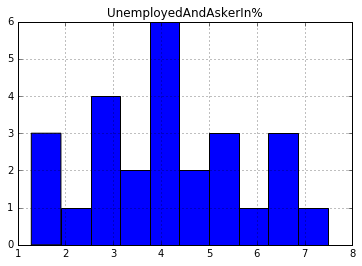

In [493]:
df_jobasker_inpercent.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C7FA6BA908>]], dtype=object)

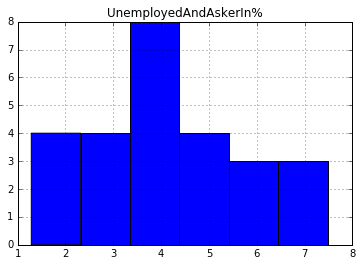

In [494]:
#Same here 6 bins seems to be the ideal
df_jobasker_inpercent.hist(bins=6)

In [495]:

with open(topo_path_json_ch) as f:
    
    j = json.load(f)
    
    # Create an own topojson object in order to display popups 
    topojson = [{'type': j['type'],
                 'objects': {'cantons': {
                     'type': "GeometryCollection",
                     'geometries': [f]}},
                 'arcs' : j['arcs'],
                 'transform' : j['transform']} 
                for f in j['objects']['cantons']['geometries']]
    
    # Add each topojson
    for tj in map(lambda tj: folium.TopoJson(tj,
                                             "objects.cantons", style_function=lambda cantons: {
                                                'fillColor': unemployment_colors(cantons['properties']['name'],df_jobasker_inpercent,'ch'),
                                                'fillOpacity': 1,
                                                'weight': 1,
                                                'color' : 'black',
                                                'dashArray' : '0, 0'}),
                  topojson):
        
        # fetch details for popup
        canton = reform(tj.data['objects']['cantons']['geometries'][0]['properties']['name'])
        unemployment_rate = ch_get_unemployment_rate(canton,df_jobasker_inpercent)
        
    
        # beautify popup
        if unemployment_rate == -1:
            html = """
                <h3> """+canton+""" </h3> </br>
                <p> Unemployment rate: unavailable </p> """
        else :
            html = """
                <h3> """+canton+""" </h3> </br>
                <p> Unemployment rate: """+"{0:.2f}%".format(unemployment_rate)+""" </p> """
            
        # add popup and topojson
        tj.add_child(folium.Popup(html))
        tj.add_to(map_switzerland2)

In [496]:
# Add legend
min_ = min(df_jobasker_inpercent['UnemployedAndAskerIn%'])
max_= max(df_jobasker_inpercent['UnemployedAndAskerIn%'])
count, division = np.histogram(df_jobasker_inpercent.iloc[:,1], bins=6)

colormap = cm.StepColormap(
            color_classes_swiss,
            index=division,
            vmin=min_,
            vmax=max_,
            caption="Unemployment rate [%]",
            )
map_switzerland2 = map_switzerland2.add_child(colormap)

In [497]:
map_switzerland2.save('swiss_unemployment_and_jobasker_rate.html')

To compare from the previous map, we can see that the canton with high unemployment rate also have a high unemployment+jobasking rate. ( Neuchatel with 7.5 %, Genève with 6.7 %)

But we also notice that some cantons that had low unemployment rate but much higher when we coutn jobasker ( east cantons such as Lucerne and Grison.

There is also the central cantons ( obwald, nidwald) that still have a low rate compared to the other.

Click [here](swiss_unemployment_and_jobasker_rate.html) to access the map from jupyter notebook.

Click [here](https://cdn.rawgit.com/maxpr/ADA/348439a5434c90edee25b42da79bd0443eb42126/03%20-%20Interactive%20Viz/swiss_unemployment_and_jobasker_rate.html) to access the map from Github.

Click on the cantons to know the exact rates.

# Swiss and Foreigners

In [498]:
#read data
path = os.path.join('FetchedData', 'Unemployment_rate_swiss_and_foreigners.xlsx')
df_unemployment_swiss_foreigners = pd.read_excel(path)

#set index to Canton and Nationality
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners.set_index(['Canton','Nationalité']).drop(['Mois'], axis = 1)

#Keep the moths that correspond to the second quaterly to match our definition
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.iloc[:,6:12]

#Keep the percentage only
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.drop(['Avril 2017.1','Mai 2017.1','Juin 2017.1'],axis=1) 
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.iloc[1:]

In [499]:
df_unemployment_swiss_foreigners_clean.head(6)

Avril 2017 Mai 2017 Juin 2017
Canton  Nationalité                              
Zurich  Etrangers            6      5.7       5.6
        Suisses            2.7      2.6       2.6
Berne   Etrangers          6.8      6.2       5.7
        Suisses              2      1.9       1.8
Lucerne Etrangers          4.6      4.3       4.1
        Suisses            1.3      1.3       1.2

In [500]:
#Compute the mean to get the rates of the second quaterly
df_unemployment_swiss_foreigners_clean['2017Q2'] = (pd.to_numeric(df_unemployment_swiss_foreigners_clean['Avril 2017'])+pd.to_numeric(df_unemployment_swiss_foreigners_clean['Mai 2017'])+pd.to_numeric(df_unemployment_swiss_foreigners_clean['Juin 2017']))/3

df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.iloc[:,3:]
df_unemployment_swiss_foreigners_clean = df_unemployment_swiss_foreigners_clean.drop(df_unemployment_swiss_foreigners_clean.index[len(df_unemployment_swiss_foreigners_clean)-1])

In [501]:
df_unemployment_swiss_foreigners_clean.head(6)

2017Q2
Canton  Nationalité          
Zurich  Etrangers    5.766667
        Suisses      2.633333
Berne   Etrangers    6.233333
        Suisses      1.900000
Lucerne Etrangers    4.333333
        Suisses      1.266667

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C78032A780>]], dtype=object)

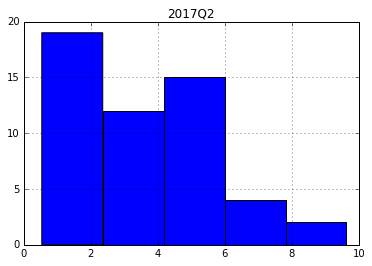

In [502]:
df_unemployment_swiss_foreigners_clean.hist(bins=5)

In [503]:
#Compute the difference between swiss and foreigners in each canton
df = df_unemployment_swiss_foreigners_clean.copy().reset_index()
for i in range(0,len(df)-1,2):
    df.loc[i,'difference'] = df.loc[i,'2017Q2']-df.loc[i+1,'2017Q2']
    df = df.drop(i+1,axis=0)
df = df.drop(['2017Q2','Nationalité'],axis=1)    
df = df.reset_index().drop('index',axis=1)

In [504]:
df

,Canton,difference
0,Zurich,3.133333
1,Berne,4.333333
2,Lucerne,3.066667
3,Uri,3.566667
4,Schwyz,2.533333
5,Obwald,2.066667
6,Nidwald,2.733333
7,Glaris,2.766667
8,Zoug,2.400000
9,Fribourg,3.000000


In [505]:
map_switzerland = folium.Map([47,9], tiles='cartodbpositron',zoom_start=7)

In [506]:
with open(topo_path_json_ch) as f:
    
    j = json.load(f)
    
    # Create an own topojson object in order to display popups 
    topojson = [{'type': j['type'],
                 'objects': {'cantons': {
                     'type': "GeometryCollection",
                     'geometries': [f]}},
                 'arcs' : j['arcs'],
                 'transform' : j['transform']} 
                for f in j['objects']['cantons']['geometries']]
    
    # Add each topojson
    for tj in map(lambda tj: folium.TopoJson(tj,
                                             "objects.cantons", style_function=lambda cantons: {
                                                'fillColor': unemployment_colors(cantons['properties']['name'],df,'ch'),
                                                'fillOpacity': 1,
                                                'weight': 1,
                                                'color' : 'black',
                                                'dashArray' : '0, 0'}),
                  topojson):
        
        # fetch details for popup
        difference_rate = ch_get_unemployment_rate(tj.data['objects']['cantons']['geometries'][0]['properties']['name'],df)
        canton = reform(tj.data['objects']['cantons']['geometries'][0]['properties']['name'])
    
        # beautify popup
        if difference_rate == -1:
            html = """
                <h3> """+canton+""" </h3> </br>
                <p> Difference between swiss and foreigners: unavailable </p> """
        else :
            html = """
                <h3> """+canton+""" </h3> </br>
                <p> Difference between swiss and foreigners: """+"{0:.2f}%".format(difference_rate)+""" </p> """
            
        # add popup and topojson
        tj.add_child(folium.Popup(html))
        tj.add_to(map_switzerland)

In [507]:
# Add legend
min_ = min(df['difference'])
max_= max(df['difference'])
count, division = np.histogram(df.iloc[:,1], bins=5)
colormap = cm.StepColormap(
            color_classes,
            index=division,
            vmin=min_,
            vmax=max_,
            caption="Difference between swiss and foreigners [%]",
            )
map_switzerland = map_switzerland.add_child(colormap)

In [508]:
map_switzerland.save('swiss_foreigners_unemployment_rate.html')

Click [here](swiss_foreigners_unemployment_rate.html) to access the map from jupyter notebook.

Click [here](https://cdn.rawgit.com/maxpr/ADA/348439a5434c90edee25b42da79bd0443eb42126/03%20-%20Interactive%20Viz/swiss_foreigners_unemployment_rate.html) to access the map from Github.

Click on the cantons to know the exact rates.

# The differences between age groups

In [509]:
#read data
path = os.path.join('FetchedData', 'Unemployment_rate_swiss_age.xlsx')
df_unemployment_swiss_foreigners_age = pd.read_excel(path)



In [510]:
#set index to Canton and Nationality
df_unemployment_swiss_foreigners_age_clean = df_unemployment_swiss_foreigners_age.set_index(['Canton','Nationalité','Classes d\'âge 15-24, 25-49, 50 ans et plus']).drop(['Unnamed: 3','Mois'], axis = 1)

#Clean and keep the moths that correspond to the second quaterly to match our definition
df_unemployment_swiss_foreigners_age_clean = df_unemployment_swiss_foreigners_age_clean.iloc[1:,3:6]
df_unemployment_swiss_foreigners_age_clean['2017Q2'] = (pd.to_numeric(df_unemployment_swiss_foreigners_age_clean['Avril 2017'])+pd.to_numeric(df_unemployment_swiss_foreigners_age_clean['Mai 2017'])+pd.to_numeric(df_unemployment_swiss_foreigners_age_clean['Juin 2017']))/3
df_unemployment_swiss_foreigners_age_clean = df_unemployment_swiss_foreigners_age_clean.iloc[:,3:]
df_unemployment_swiss_foreigners_age_clean = df_unemployment_swiss_foreigners_age_clean.reset_index()

In [511]:
age_cat = 'Classes d\'âge 15-24, 25-49, 50 ans et plus'

In [512]:
df = df_unemployment_swiss_foreigners_age_clean.copy()
df = df.fillna('')
df.head()

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",2017Q2
0,Zurich,Etrangers,1,949.666667
1,Zurich,Etrangers,2,9727.666667
2,Zurich,Etrangers,3,2453.666667
3,Zurich,Etrangers,Total,13131.000000
4,Zurich,Suisses,1,1981.000000


In [513]:
# construct the dataFrame "totals" that contains the total number of foreigners and the total number of swiss 
#for each canton

df = df.dropna(axis=0).reset_index().drop('index', axis=1)
idx = 3
totals = []
max_ = int(len(df)/4)

for i in range(0,max_):
    total = pd.to_numeric(df.loc[idx,['2017Q2']])
    totals.append(total)
    if (idx < len(df)-4):
        idx += 4

In [514]:
totals = pd.DataFrame(totals).reset_index()
totals = totals.iloc[:,1:]

#Remove the total lines for the principal data frame 
df = df[df[age_cat].str.contains('Total') == False]
df = df.dropna(axis=0).reset_index().drop('index', axis=1)




In [515]:
#Compute the rates using the number of people in each age category and the numbers stored in "totals" dataframe
k = 0
for i in range(len(totals)):
    for j in range(k,k+3):
        df.loc[j,'2017Q2 in %'] = 100 * pd.to_numeric(df.loc[j,'2017Q2']) / pd.to_numeric(totals.loc[i,'2017Q2'])
        
    k+=3

In [516]:
df.head(12)

,Canton,Nationalité,"Classes d'âge 15-24, 25-49, 50 ans et plus",2017Q2,2017Q2 in %
0,Zurich,Etrangers,1,949.666667,7.232249
1,Zurich,Etrangers,2,9727.666667,74.081690
2,Zurich,Etrangers,3,2453.666667,18.686061
3,Zurich,Suisses,1,1981.000000,12.726455
4,Zurich,Suisses,2,8802.000000,56.546319
5,Zurich,Suisses,3,4783.000000,30.727226
6,Zurich,Total,,28697.000000,2464.672202
7,Berne,Etrangers,1,518.333333,44.517607
8,Berne,Etrangers,2,3838.333333,329.659319
9,Berne,Etrangers,3,1164.333333,39.630134


In most cantons, the number of registered unemployed people is bigger for swiss than for foreigners, but there are some exceptions like Bâle-Ville. 

Let's plot some examples to see these differences.

# Jura

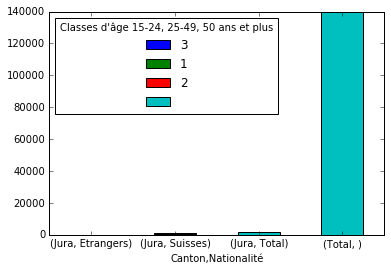

In [517]:
df.tail(6).groupby(['Canton','Nationalité',age_cat])['2017Q2'].sum().unstack([age_cat]).plot(kind = 'bar',rot = 0,stacked=True)

We can clearly see a big difference between Swiss and foreigners. However, the difference between age group is nearly the same.

# Genève

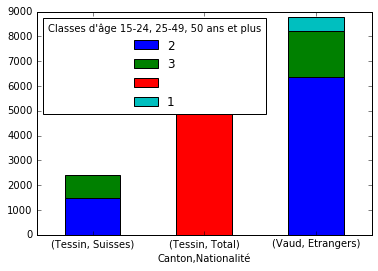

In [518]:
df.loc[144:149,:].groupby(['Canton','Nationalité',age_cat])['2017Q2'].sum().unstack([age_cat]).plot(kind = 'bar',rot = 0,stacked=True)

In Geneva, the difference is really small, but the number of registered unemployed foreigners in age category 2 is bigger than the number of registered unemployed swiss people in the same category.

# Bâle-Ville

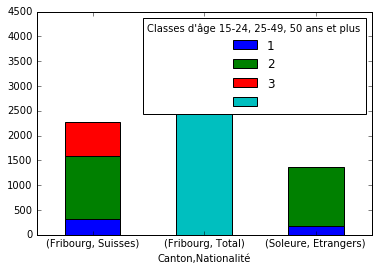

In [519]:
df.loc[66:71,:].groupby(['Canton','Nationalité',age_cat])['2017Q2'].sum().unstack([age_cat]).plot(kind = 'bar',rot = 0,stacked=True)

In Bâle-Ville, we observe that the number of registered unemployed foreigners is bigger than the number of registered unemployed swiss people.